In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import date, datetime
import matplotlib.pyplot as plt
from missingpy import KNNImputer
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from tqdm import tqdm
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from time import time

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
features = pd.read_csv("sensors.csv")

In [3]:
target = pd.read_csv("reactor_pressure_target.csv")

In [4]:
data = pd.merge(features, target, how = 'left', on = 'timestamp')

In [5]:
## генерим временные фичи

data['timestamp'] = pd.to_datetime(data['timestamp'])
data['time'] = data['timestamp'].dt.strftime("%Y%m%d%H%M%S")
data['time'] = data['time'].astype(float) / 10000
data['month'] = (data['time'].astype(str).str[4:6]).astype(int)
data['hour'] = (data['time'].astype(str).str[8:10]).astype(int)
data['day'] = data['timestamp'].dt.dayofweek
data['week'] = data['timestamp'].dt.weekofyear
data['beg'] = data['timestamp'].dt.is_month_start
data['end'] = data['timestamp'].dt.is_month_end

In [6]:
## список фичей, по которым будут заполняться пропуски

list1 = ['f_3', 'f_4', 'f_5', 'f_6', 'f_7',
       'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16',
       'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_22', 'f_23', 'f_24', 'f_25',
       'f_26', 'f_27', 'f_28', 'f_29', 'f_30', 'f_31', 'f_32', 'f_33', 'f_34',
       'f_35', 'f_43','f_36', 'f_37', 'f_38', 'f_39', 'f_40',
       'f_44', 'f_45', 'f_46', 'f_47', 'time', 'month', 'hour', 'day', 'week', 'beg', 'end']

In [7]:
train = data[~data['target'].isnull()]
test = data[data['target'].isnull()]
[len(train), len(test)]

[10400, 2872]

In [8]:
## заполняем пропуски KNN: обучаем на трейне, заполняем трейн и тест

imputer = KNNImputer()
imp = imputer.fit(train[list1])
data[list1] = imp.transform(data[list1])

C:\ProgramData\Anaconda3\lib\site-packages\missingpy\knnimpute.py:224: UserWarning: There are rows with more than 50.0% missing values. These rows are not included as donor neighbors.
  .format(self.row_max_missing * 100))
C:\ProgramData\Anaconda3\lib\site-packages\missingpy\knnimpute.py:282: UserWarning: There are rows with more than 50.0% missing values. The missing features in these rows are imputed with column means.
  .format(self.row_max_missing * 100))
C:\ProgramData\Anaconda3\lib\site-packages\missingpy\utils.py:124: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


In [9]:
train = data[~data['target'].isnull()]
test = data[data['target'].isnull()]

In [10]:
## заменяем "странные" отрицательные значения фичей на нули

list3 = ['f_3', 'f_4', 'f_5', 'f_6', 'f_7',
       'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16',
       'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_22', 'f_23', 'f_24', 'f_25',
       'f_26', 'f_27', 'f_28', 'f_29', 'f_30', 'f_31', 'f_32', 'f_33', 'f_34',
       'f_35', 'f_43','f_36', 'f_37', 'f_38', 'f_39', 'f_40',
       'f_44', 'f_45', 'f_46', 'f_47', 'time', 'month', 'hour', 'day', 'week', 'beg', 'end']
for feature in list3:
    train[str(feature)][train[str(feature)] < 0] = 0
    test[str(feature)][test[str(feature)] < 0] = 0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:7626: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2961: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_

In [11]:
## список фичей для Bagging (отбирались те, что без пропусков + по feature importance)

list1 = ['f_3', 'f_4', 'f_6', 'f_7',
       'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16',
       'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_22', 'f_23', 'f_24', 'f_25',
       'f_26', 'f_27', 'f_28', 'f_29', 'f_30', 'f_31', 'f_32', 'f_33', 'f_34',
       'f_35', 'f_43','f_36', 'f_37', 'f_38', 'f_39', 'f_40',
       'f_44', 'f_45', 'f_46', 'f_47', 'time', 'month', 
       'day', 'week', 'beg', 'end']

In [12]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [13]:
## Bagging - на всякий случай для устойчивости усредняем прогнозы с 10 разными random state

subm_bag = 0.0
num_ensembles = 10
for i in tqdm(range(num_ensembles)):
    Xtrn, Xtest, Ytrn, Ytest = train_test_split(train[list1], train['target'], random_state = 42, test_size = 0.25, shuffle = False)
    bag = BaggingRegressor(n_estimators = 15, max_samples = 0.7, random_state = 42 * i, max_features = 0.7).fit(Xtrn, Ytrn)
    test_bag = bag.predict(Xtest)
    rmse2 = rmse(test_bag, Ytest)
    bag = BaggingRegressor(n_estimators = 15, max_samples = 0.7, random_state = 42 * i, max_features = 0.7).fit(train[list1], train['target'])
    subm_bag += bag.predict(test[list1])
    print('rmse_bag', rmse2.mean())
subm_bag = subm_bag / num_ensembles

  0%|          | 0/10 [00:00<?, ?it/s]

rmse_bag 11.256544689379275


 10%|█         | 1/10 [00:05<00:45,  5.08s/it]

rmse_bag 11.107142911147914


 20%|██        | 2/10 [00:09<00:39,  4.94s/it]

rmse_bag 11.231969242704519


 30%|███       | 3/10 [00:15<00:35,  5.10s/it]

rmse_bag 11.069506524520802


 40%|████      | 4/10 [00:20<00:31,  5.30s/it]

rmse_bag 11.281863150793741


 50%|█████     | 5/10 [00:26<00:27,  5.47s/it]

rmse_bag 11.09104307980089


 60%|██████    | 6/10 [00:31<00:21,  5.28s/it]

rmse_bag 11.03766512191154


 70%|███████   | 7/10 [00:36<00:15,  5.03s/it]

rmse_bag 11.203961242031923


 80%|████████  | 8/10 [00:40<00:09,  4.96s/it]

rmse_bag 11.27378732075602


 90%|█████████ | 9/10 [00:45<00:04,  4.78s/it]

rmse_bag 11.330565537738282


100%|██████████| 10/10 [00:49<00:00,  4.71s/it]


In [14]:
## список фичей для lightgbm (отбирались по feature importance, есть фичи с пропусками)

list2 = ['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_6', 'f_7',
       'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16',
       'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_22', 'f_23', 'f_24', 'f_25',
       'f_26', 'f_27', 'f_28', 'f_29', 'f_30', 'f_31', 'f_32', 'f_33', 'f_34',
       'f_35', 'f_36', 'f_37', 'f_38', 'f_39', 'f_40', 'f_41', 'f_42', 'f_43',
       'f_44', 'f_45', 'f_46', 'f_47', 'time', 'month', 
       'day', 'beg', 'end']

In [15]:
##lightgbm - на всякий случай для устойчивости усредняем прогнозы с 10 разными random state

subm_gbm = 0.0
num_ensembles = 10
for i in tqdm(range(num_ensembles)):
    Xtrn, Xtest, Ytrn, Ytest = train_test_split(train[list2], train['target'], random_state = 42, test_size = 0.25, shuffle = False)
    gbm = lgb.LGBMRegressor(boosting_type = 'gbdt', num_boost_round = int(0.5 * len(Xtrn)), objective = 'mse', num_leaves = 3, 
        learning_rate = 0.1, feature_fraction = 0.6, bagging_fraction= 0.75, bagging_freq= 5, seed= 42 * i, boost_from_average= True,
        reg_sqrt = True, min_child_samples = int(0.05 * len(Xtrn))).fit(Xtrn, Ytrn)
    test_gbm = gbm.predict(Xtest)
    rmse2 = rmse(test_gbm, Ytest)
    gbm = lgb.LGBMRegressor(boosting_type = 'gbdt', num_boost_round = int(0.5 * len(train)), objective = 'mse', num_leaves = 3, 
        learning_rate = 0.1, feature_fraction = 0.6, bagging_fraction= 0.75, bagging_freq= 5, seed= 42 * i, boost_from_average= True,
        reg_sqrt = True, min_child_samples = int(0.05 * len(train))).fit(train[list2], train['target'])
    subm_gbm += gbm.predict(test[list2])
    print('rmse_gbm', rmse2.mean())
subm_gbm = subm_gbm / num_ensembles

  0%|          | 0/10 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


rmse_gbm 9.600601185537922


 10%|█         | 1/10 [00:07<01:04,  7.21s/it]C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


rmse_gbm 9.407726381892473


 20%|██        | 2/10 [00:14<00:57,  7.19s/it]C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


rmse_gbm 9.604818134882436


 30%|███       | 3/10 [00:21<00:49,  7.13s/it]C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


rmse_gbm 9.480707472072861


 40%|████      | 4/10 [00:29<00:43,  7.33s/it]C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


rmse_gbm 9.630025211370992


 50%|█████     | 5/10 [00:36<00:37,  7.41s/it]C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


rmse_gbm 9.285289606381882


 60%|██████    | 6/10 [00:44<00:29,  7.50s/it]C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


rmse_gbm 9.577958850022455


 70%|███████   | 7/10 [00:51<00:22,  7.38s/it]C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


rmse_gbm 9.691652478338222


 80%|████████  | 8/10 [00:59<00:15,  7.56s/it]C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


rmse_gbm 9.455606258970052


 90%|█████████ | 9/10 [01:06<00:07,  7.50s/it]C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


rmse_gbm 9.329174386262117


100%|██████████| 10/10 [01:13<00:00,  7.33s/it]


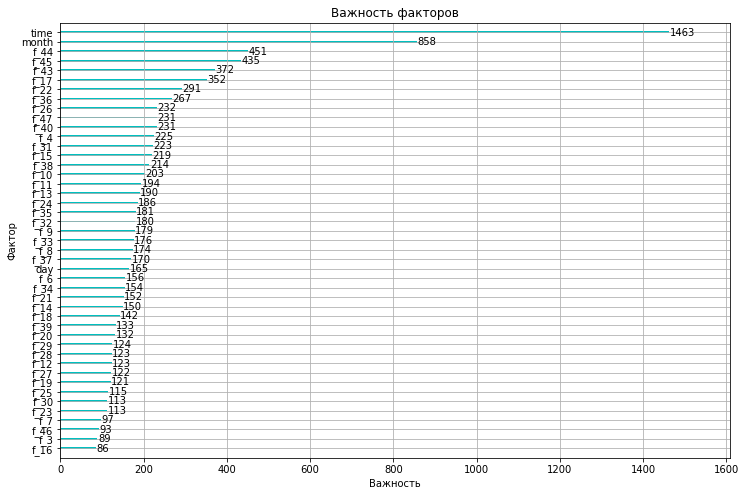

In [16]:
plt.rcParams["figure.figsize"] = (12, 8)
ax = lgb.plot_importance(gbm, max_num_features = 100, color = 'c')
plt.title('Важность факторов')
plt.xlabel('Важность')
plt.ylabel('Фактор')
plt.show()

In [17]:
## дальше пробуем выделить тренд и сезонность с помощью holt-winters и экспоненциального сглаживания

ser = pd.Series(np.array(data['target']), index = data['timestamp'])
train2 = ser[~ser.isnull()]
test2 = ser[ser.isnull()]
train1, test1 = ser.iloc[:9000], ser.iloc[9000:10400]
model = Holt(train1[7500:]).fit()
pred = model.predict(start=test1.index[0], end=test1.index[-1])
model2 = SimpleExpSmoothing(train1).fit()
pred2 = model2.predict(start=test1.index[0], end=test1.index[-1])

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


0.8627242429996683
2.985312939343601


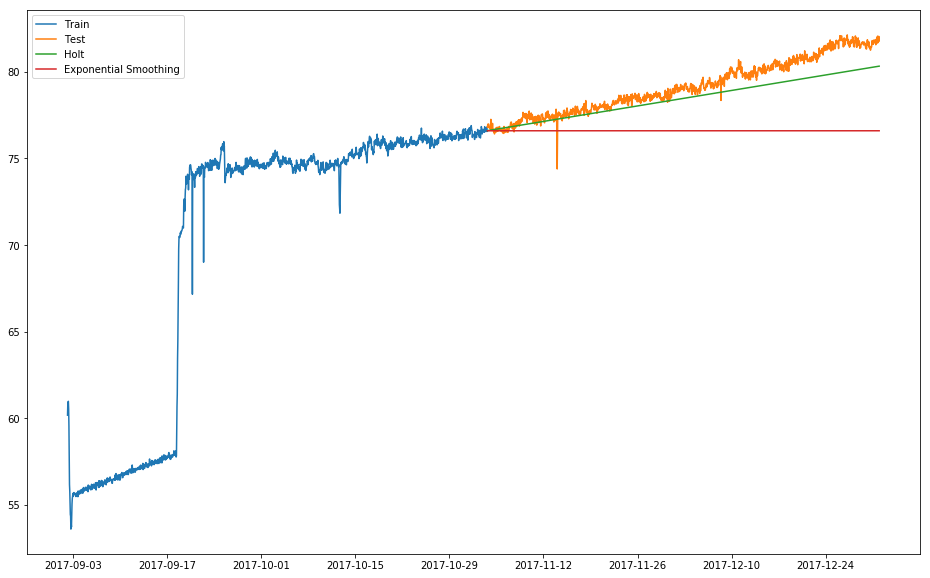

In [18]:
plt.rcParams["figure.figsize"] = (16, 10)
plt.plot(train1.index[7500:], train1[7500:], label='Train')
plt.plot(test1.index, test1, label='Test')
plt.plot(pred.index, pred, label='Holt')
plt.plot(pred2.index, pred2, label='Exponential Smoothing')
plt.legend(loc='best')
print(rmse(pred, test1))
print(rmse(pred2, test1))

In [19]:
## holt-winters выглядит хорошо, пробудем его

model = Holt(train2[7950:]).fit()
pred = model.predict(start=test2.index[0], end=test2.index[-1])

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


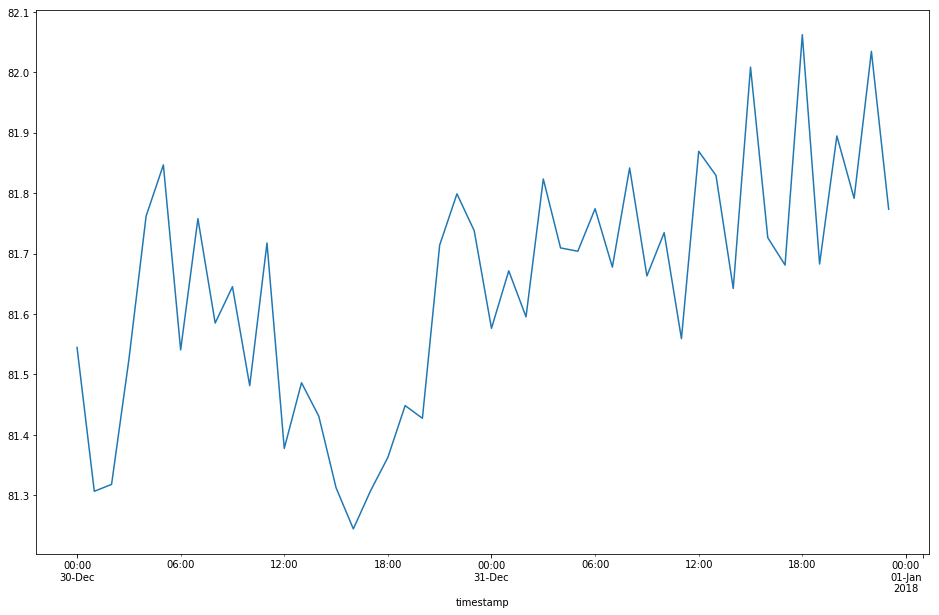

In [20]:
## на последних двух днях трейна видим "забор"

train2[-48:].plot()

In [21]:
## дальше ML заканчивается :), пытаемся вручную заделать "забор" на будущее, выделяем средние колебания и небольшой тренд

[np.abs(train2[8000:].diff()).mean(), train2[8000:].diff().mean()]

[0.15720611403896786, 0.002974975640908811]

In [22]:
## рисуем на будущее "забор"

pred5 = pd.Series(pred.copy())
pred5.iloc[0] = 81.773417 + 0.1
for i in tqdm(range(1, len(pred))):
    pred5.iloc[i] = 0.16 * ((-1)**(i)) + pred5.iloc[i-1] + 0.002

100%|██████████| 2871/2871 [00:00<00:00, 9530.97it/s]


In [23]:
## блендим "забор" с моделями ML: 
## берем отклонения моделей от их среднего прогноза, 
## затем блендим эти отклонения линейной комбинацией (65% на 35% - подбиралось по CV), 
## затем накладываем блендинг отклонений на "забор"

pred_gbm = (- np.mean(subm_gbm) + subm_gbm)
pred_bag = (- np.mean(subm_bag) + subm_bag)
pred_5 = (- np.mean(pred5) + pred5)
pred3 = 0.65 * pred_gbm + 0.35 * pred_bag + pred5

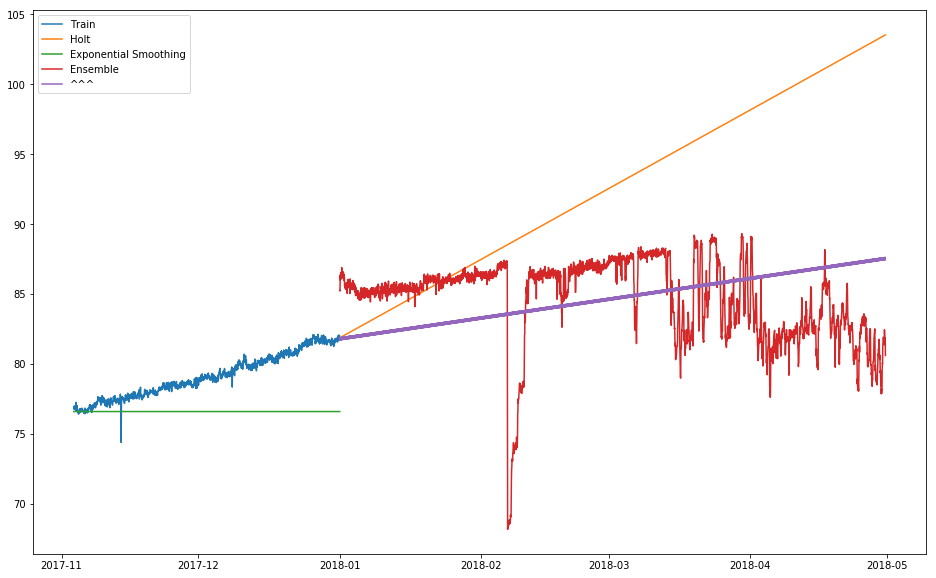

In [24]:
plt.rcParams["figure.figsize"] = (16, 10)
plt.plot(train2.index[9000:], train2[9000:], label = 'Train')
plt.plot(pred.index, pred, label = 'Holt')
plt.plot(pred2.index, pred2, label = 'Exponential Smoothing')
plt.plot(pred.index, pred3, label = 'Ensemble')
plt.plot(pred.index, pred5, label = '^^^')
plt.legend(loc = 'best')

In [26]:
## итоговый сабмит ("забор" сработал лучше, чем holt-winters и exponential smoothing, поэтому оставили его)

subm = 0.0 * (0.0 * subm_gbm + 0.0 * subm_bag) + 0.0 * np.array(pred) + 1.0 * np.array(pred3)

In [27]:
subm

array([85.24240548, 85.21010933, 86.32480708, ..., 81.80289592,
       81.88392159, 80.60218377])

In [28]:
subm = pd.Series(subm, name = 'target', index = test2.index)

In [29]:
subm.to_csv("subm_task2_" + str(time()) + ".csv", header = ['target'], index_label = ['timestamp'])